# Full Dirichlet VPINN example

In [1]:
from mesh import *

from VPINN_tri_final import *

from PROBDEF import PROBDEF

import os; os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
import logging; logging.getLogger('tensorflow').setLevel(logging.ERROR)

tfk = tf.keras
tfkl = tf.keras.layers

# importing probdef 
pb = PROBDEF()

2023-11-30 23:44:38.543092: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-30 23:44:38.564905: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-30 23:44:38.773545: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-30 23:44:38.776030: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-30 23:44:40.144204: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co


my_types lib imported

generate mesh lib imported

interpolator_lib imported

settings_lib imported 




### Initialise mesh

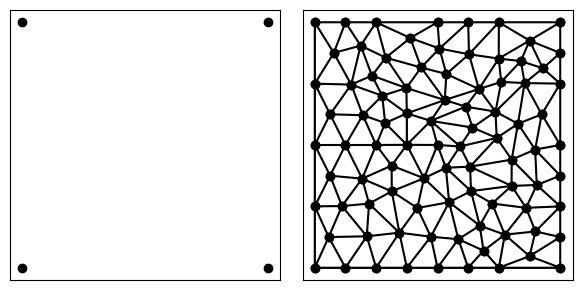

In [2]:
# seed for reproducibility
initializer = tf.keras.initializers.GlorotUniform(seed=54)


# mesh init
domain = ((0, 0), (1, 0), (1, 1), (0, 1))
mesh = generate_mesh(domain, 0.01)

### Train boundary condition network

In [3]:
#net used for approximating the fully dirichlet bc  
bc_model = tfk.models.Sequential()
bc_model.add(tf.keras.Input(shape=(2,),dtype=tf_type))
bc_model.add(tfkl.Dense(10, activation='tanh',kernel_initializer=initializer,dtype=tf_type,bias_initializer=initializer))
bc_model.add(tfkl.Dense(10, activation='tanh',kernel_initializer=initializer,dtype=tf_type,bias_initializer=initializer))
bc_model.add(tfkl.Dense(10, activation='tanh',kernel_initializer=initializer,dtype=tf_type,bias_initializer=initializer))
bc_model.add(tfkl.Dense(10, activation='tanh',kernel_initializer=initializer,dtype=tf_type,bias_initializer=initializer))
bc_model.add(tf.keras.layers.Dense(1,activation='linear',kernel_initializer=initializer,dtype=tf_type,use_bias=True))

In [4]:
print(bc_model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                30        
                                                                 
 dense_1 (Dense)             (None, 10)                110       
                                                                 
 dense_2 (Dense)             (None, 10)                110       
                                                                 
 dense_3 (Dense)             (None, 10)                110       
                                                                 
 dense_4 (Dense)             (None, 1)                 11        
                                                                 
Total params: 371 (2.90 KB)
Trainable params: 371 (2.90 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [5]:
# setting model to the current net
model = bc_model


# helper function to treat the net as a lamda function
def model_np(x, y):
    eval = tf.constant([[x, y]], dtype=tf.float64)
    return model(eval).numpy()[0, 0]

In [6]:
def plot_BC(u_exact, u_NN_BC_):
    """both numpy functions"""
    x = np.linspace(0, 1, 200, dtype=np.float64)

    eval_exact = [u_exact(x[i], 1.0) for i in range(len(x))]

    eval_net = [u_NN_BC_(x[i], 1.0) for i in range(len(x))]

    eval_exact = np.array(eval_exact)
    eval_net = np.array(eval_net)

    plt.figure(figsize=(10,7))  # Set the figure size

    # Plot the data
    plt.subplot(221)   
    plt.plot(x, eval_net, label="eval_net", linestyle="-", marker="o", color="b", markersize=2)
    plt.plot(x, eval_exact, label="eval_exact", linestyle="--", marker="x", color="r", markersize=2)
    plt.grid()
    plt.title("top edge")
    plt.legend()

    eval_exact = [u_exact(x[i], 0.0) for i in range(len(x))]
    eval_net = [u_NN_BC_(x[i], 0.0) for i in range(len(x))]
    eval_exact = np.array(eval_exact)
    eval_net = np.array(eval_net)

    # plt.figure(figsize=(8, 6))  # Set the figure size

    # Plot the data
    plt.subplot(223)    
    plt.plot(x, eval_net, label="eval_net", linestyle="-", marker="o", color="b", markersize=2)
    plt.plot(x, eval_exact, label="eval_exact", linestyle="--", marker="x", color="r", markersize=2)
    plt.grid()
    plt.title("bottom edge")
    plt.legend()

    eval_exact = [u_exact(1.0, x[i]) for i in range(len(x))]
    eval_net = [u_NN_BC_(1.0, x[i]) for i in range(len(x))]
    eval_exact = np.array(eval_exact)
    eval_net = np.array(eval_net)

    # plt.figure(figsize=(8, 6))  # Set the figure size

    # Plot the data
    plt.subplot(222)    
    plt.plot(x, eval_net, label="eval_net", linestyle="-", marker="o", color="b", markersize=2)
    plt.plot(x, eval_exact, label="eval_exact", linestyle="--", marker="x", color="r", markersize=2)
    plt.grid()
    plt.title("right edge")
    plt.legend()

    eval_exact = [u_exact(0.0, x[i]) for i in range(len(x))]
    eval_net = [u_NN_BC_(0.0, x[i]) for i in range(len(x))]
    eval_exact = np.array(eval_exact)
    eval_net = np.array(eval_net)

    # plt.figure(figsize=(8, 6))  # Set the figure size

    # Plot the data
    plt.subplot(224)   
    plt.plot(x, eval_net, label="eval_net", linestyle="-", marker="o", color="b", markersize=2)
    plt.plot(x, eval_exact, label="eval_exact", linestyle="--", marker="x", color="r", markersize=2)
    plt.grid()
    plt.title("left edge")
    plt.legend()

    eval_exact = [u_exact(x[i], 0.5) for i in range(len(x))]
    eval_net = [u_NN_BC_(x[i], 0.5) for i in range(len(x))]
    eval_exact = np.array(eval_exact)
    eval_net = np.array(eval_net)

    plt.figure(figsize=(10, 7))  # Set the figure size

    # Plot the data
    plt.subplot(221)
    plt.plot(x, eval_net, label="eval_net", linestyle="-", marker="o", color="b", markersize=2)
    plt.plot(x, eval_exact, label="eval_exact", linestyle="--", marker="x", color="r", markersize=2)
    plt.grid()
    plt.title("slice in the middle y=0.5")
    plt.legend()

    eval_exact = [u_exact(x[i], 0.25) for i in range(len(x))]
    eval_net = [u_NN_BC_(x[i], 0.25) for i in range(len(x))]
    eval_exact = np.array(eval_exact)
    eval_net = np.array(eval_net)

    # plt.figure(figsize=(8, 6))  # Set the figure size

    # Plot the data
    plt.subplot(222)
    plt.plot(x, eval_net, label="eval_net", linestyle="-", marker="o", color="b", markersize=2)
    plt.plot(x, eval_exact, label="eval_exact", linestyle="--", marker="x", color="r", markersize=2)
    plt.grid()
    plt.title("slice in the middle y=0.25")
    plt.legend()

    eval_exact = [u_exact(x[i], 0.75) for i in range(len(x))]
    eval_net = [u_NN_BC_(x[i], 0.75) for i in range(len(x))]
    eval_exact = np.array(eval_exact)
    eval_net = np.array(eval_net)

    # plt.figure(figsize=(8, 6))  # Set the figure size

    # Plot the data
    plt.subplot(223)
    plt.plot(x, eval_net, label="eval_net", linestyle="-", marker="o", color="b", markersize=2)
    plt.plot(x, eval_exact, label="eval_exact", linestyle="--", marker="x", color="r", markersize=2)
    plt.grid()
    plt.title("slice in the middle y=0.75")
    plt.legend()

    eval_exact = [u_exact(0.5, x[i]) for i in range(len(x))]
    eval_net = [u_NN_BC_(0.5, x[i]) for i in range(len(x))]
    eval_exact = np.array(eval_exact)
    eval_net = np.array(eval_net)

    # plt.figure(figsize=(8, 6))  # Set the figure size

    # Plot the data
    plt.subplot(224)
    plt.plot(x, eval_net, label="eval_net", linestyle="-", marker="o", color="b", markersize=2)
    plt.plot(x, eval_exact, label="eval_exact", linestyle="--", marker="x", color="r", markersize=2)
    plt.grid()
    plt.title("slice in the middle x=0.50")
    plt.legend()

def helper_colour_plot(x, y, model):

    x_=tf.reshape(x,(-1,1))
    y_=tf.reshape(y,(-1,1))

    eval=tf.concat([x_,y_],axis=1)

    return tf.reshape(model(eval),(tf.shape(x)[0],-1))

def color_plot(model):

    x = np.linspace(0, 1, 1000)
    y = np.linspace(0, 1, 1000)

    X, Y = np.meshgrid(x, y)

    error = np.abs(pb.u_exact_np(X,Y)-helper_colour_plot(X,Y,model))

    fig=plt.imshow(
        error,
        extent=[min(x), max(x), min(y), max(y)],
        vmin=np.min(error),
        vmax=np.max(error)
    )

    plt.title('Error Map')
    plt.colorbar(fig)

    fig.axes.set_autoscale_on(False)

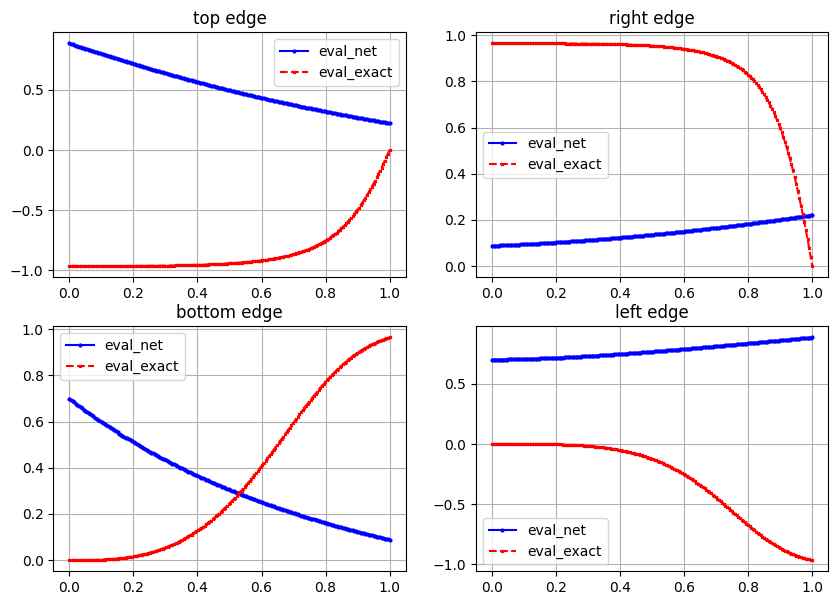

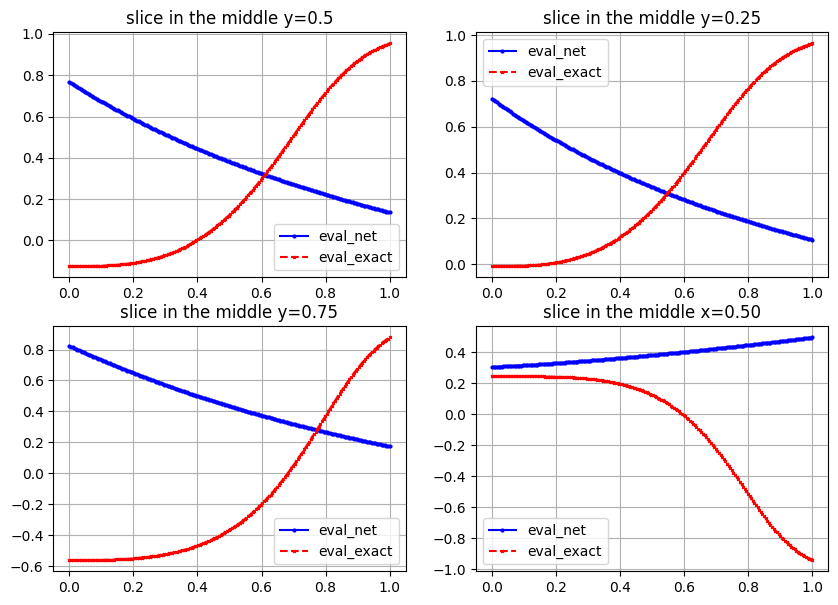

In [7]:
# Compare untrained model to the exact version
plot_BC(pb.u_exact_np,model_np)

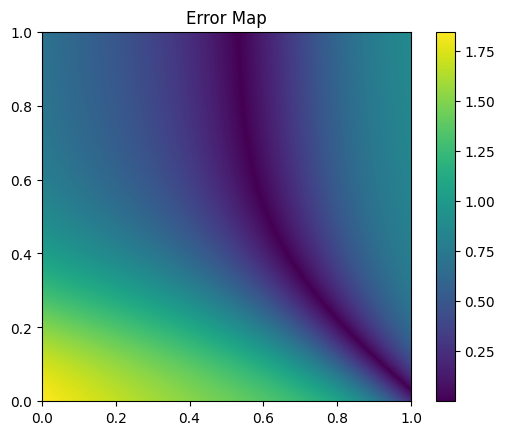

In [8]:
color_plot(bc_model)

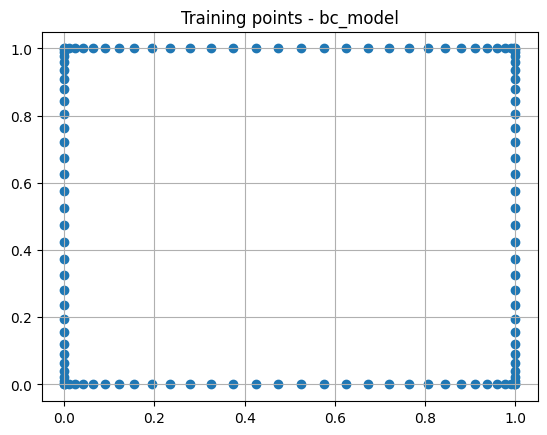

In [9]:
# Generate training data for the network
x = pb.generate_boundary_points(30, False)
plt.scatter(x[:, 0], x[:, 1])
plt.title("Training points - bc_model")
plt.grid()

y = pb.u_exact(x[:, 0], x[:, 1])
y = tf.reshape(y, (-1, 1))

In [10]:
# Training process of bc_model with the MSE as loss function 
custom_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)  # Adjust the learning rate as needed
bc_model.compile(optimizer=custom_optimizer, loss='mean_squared_error')

history=model.fit(x, y, epochs=3000, batch_size=np.size(y))

Epoch 1/3000
1/1 [==============================] - 1s 860ms/step - loss: 1.0634
Epoch 2/3000
1/1 [==============================] - 0s 5ms/step - loss: 1.0161
Epoch 3/3000
1/1 [==============================] - 0s 5ms/step - loss: 0.9720
Epoch 4/3000
1/1 [==============================] - 0s 3ms/step - loss: 0.9312
Epoch 5/3000
1/1 [==============================] - 0s 3ms/step - loss: 0.8936
Epoch 6/3000
1/1 [==============================] - 0s 3ms/step - loss: 0.8591
Epoch 7/3000
1/1 [==============================] - 0s 6ms/step - loss: 0.8275
Epoch 8/3000
1/1 [==============================] - 0s 2ms/step - loss: 0.7985
Epoch 9/3000
1/1 [==============================] - 0s 2ms/step - loss: 0.7718
Epoch 10/3000
1/1 [==============================] - 0s 3ms/step - loss: 0.7472
Epoch 11/3000
1/1 [==============================] - 0s 8ms/step - loss: 0.7243
Epoch 12/3000
1/1 [==============================] - 0s 4ms/step - loss: 0.7029
Epoch 13/3000
1/1 [============================

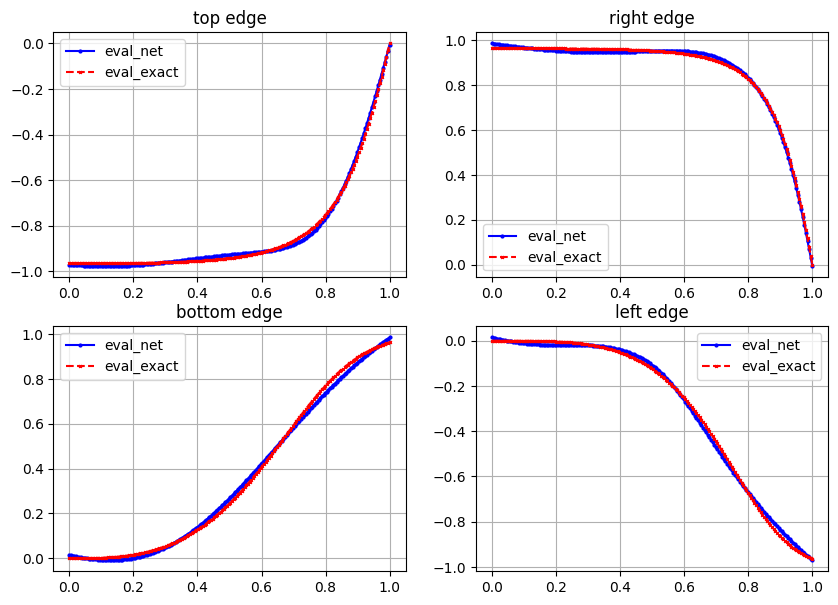

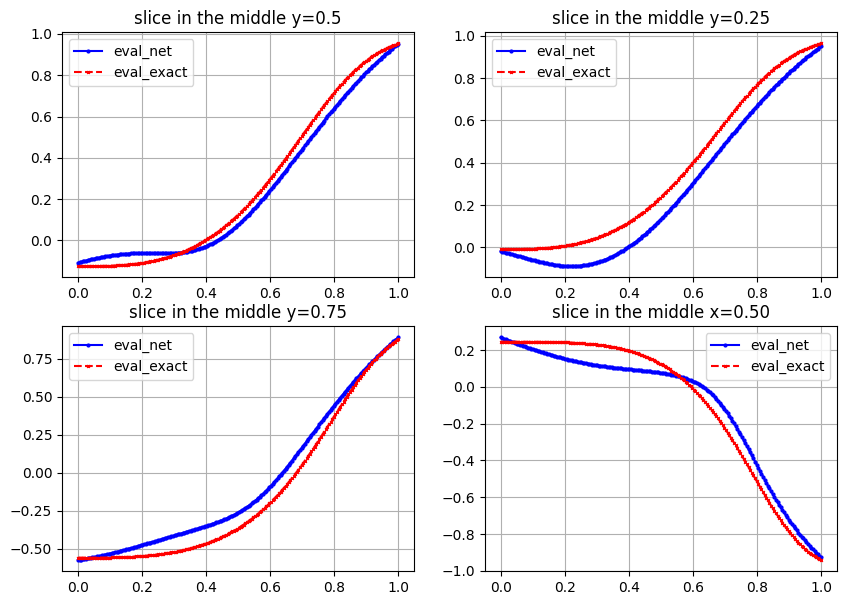

In [11]:
# Compare with the now trained network
plot_BC(pb.u_exact_np,model_np)

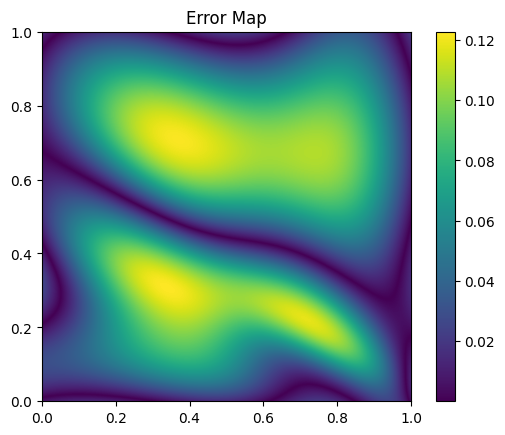

In [12]:
color_plot(bc_model)

In [13]:
# Make the bc_model non-trianable
for layer in bc_model.layers:
    layer.trainable = False

# Display model summary after making weights non-trainable
bc_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                30        
                                                                 
 dense_1 (Dense)             (None, 10)                110       
                                                                 
 dense_2 (Dense)             (None, 10)                110       
                                                                 
 dense_3 (Dense)             (None, 10)                110       
                                                                 
 dense_4 (Dense)             (None, 1)                 11        
                                                                 
Total params: 371 (2.90 KB)
Trainable params: 0 (0.00 Byte)
Non-trainable params: 371 (2.90 KB)
_________________________________________________________________


###  VPINN MODEL

In [14]:
# Create the network to be trained on the variational form
MODEL = tfk.models.Sequential()
MODEL.add(tf.keras.Input(shape=(2,),dtype=tf_type))
MODEL.add(tfkl.Dense(50, activation='tanh',kernel_initializer=initializer,dtype=tf_type,bias_initializer=initializer))
MODEL.add(tfkl.Dense(50, activation='tanh',kernel_initializer=initializer,dtype=tf_type,bias_initializer=initializer))
MODEL.add(tfkl.Dense(50, activation='tanh',kernel_initializer=initializer,dtype=tf_type,bias_initializer=initializer))
MODEL.add(tf.keras.layers.Dense(1,activation='linear',kernel_initializer=initializer,dtype=tf_type,use_bias=True))

MODEL.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 50)                150       
                                                                 
 dense_6 (Dense)             (None, 50)                2550      
                                                                 
 dense_7 (Dense)             (None, 50)                2550      
                                                                 
 dense_8 (Dense)             (None, 1)                 51        
                                                                 
Total params: 5301 (41.41 KB)
Trainable params: 5301 (41.41 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


#### Problem parameters

In [18]:
# order of test function 
N_test = 2

params = {'scheme': 'VPINNs','N_test':N_test}



basis:
basis function number :  1

1 x^0 y^0 -3 x^1 y^0 2 x^2 y^0 -3 x^0 y^1 4 x^1 y^1 2 x^0 y^2 

basis function number :  2

0 x^0 y^0 4 x^1 y^0 -4 x^2 y^0 0 x^0 y^1 -4 x^1 y^1 0 x^0 y^2 

basis function number :  3

0 x^0 y^0 -1 x^1 y^0 2 x^2 y^0 0 x^0 y^1 0 x^1 y^1 0 x^0 y^2 

basis function number :  4

0 x^0 y^0 0 x^1 y^0 0 x^2 y^0 4 x^0 y^1 -4 x^1 y^1 -4 x^0 y^2 

basis function number :  5

0 x^0 y^0 0 x^1 y^0 0 x^2 y^0 0 x^0 y^1 4 x^1 y^1 0 x^0 y^2 

basis function number :  6

0 x^0 y^0 0 x^1 y^0 0 x^2 y^0 -1 x^0 y^1 0 x^1 y^1 2 x^0 y^2 

basis :
d1x
basis function number :  1

-3 x^0 y^0 4 x^1 y^0 4 x^0 y^1 

d1y
basis function number :  1

-3 x^0 y^0 4 x^1 y^0 4 x^0 y^1 


d1x
basis function number :  2

4 x^0 y^0 -8 x^1 y^0 -4 x^0 y^1 

d1y
basis function number :  2

0 x^0 y^0 -4 x^1 y^0 0 x^0 y^1 


d1x
basis function number :  3

-1 x^0 y^0 4 x^1 y^0 0 x^0 y^1 

d1y
basis function number :  3

0 x^0 y^0 0 x^1 y^0 0 x^0 y^1 


d1x
basis function number :  4

0 x^0 y^0 0 

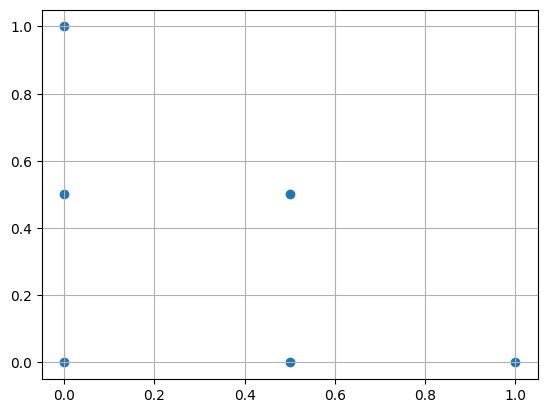

-->mesh : 
     n_triangles :  150
     n_vertices  :  88
     n_edges     :  237
     h_max           :  0.25
     h_min           :  0.0895721626833764
-->test_fun      : 
     order       :  2
     dof         :  277


In [19]:
# Initialise VPINN class
vp=VPINN(pb,params,mesh,True,NN=MODEL)
model=vp.u_NN_BC
vp.set_bc_model(bc_model)

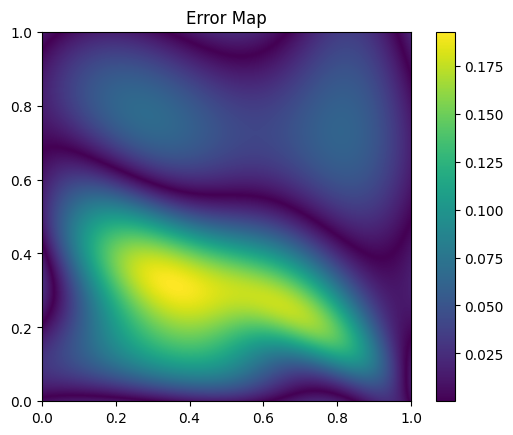

In [20]:
vp.set_bc_model(bc_model)
color_plot(vp.NN_imposeBC)

In [21]:
# Start training
history=vp.train(2000,0.001,bc_model)

Iteration: 0 loss: 0.0018985988 time: 33.60496973991394
Iteration: 10 loss: 0.0017473430 time: 0.6600141525268555
Iteration: 20 loss: 0.0016071970 time: 0.6587023735046387
Iteration: 30 loss: 0.0014614997 time: 0.6445980072021484
Iteration: 40 loss: 0.0013470867 time: 0.6676404476165771
Iteration: 50 loss: 0.0013167019 time: 0.6262075901031494
Iteration: 60 loss: 0.0013130751 time: 0.6210966110229492
Iteration: 70 loss: 0.0012972323 time: 0.6134049892425537
Iteration: 80 loss: 0.0012808338 time: 0.6577682495117188
Iteration: 90 loss: 0.0012538520 time: 0.6168155670166016
Iteration: 100 loss: 0.0012055613 time: 0.6312918663024902
Iteration: 110 loss: 0.0011207366 time: 0.6104934215545654
Iteration: 120 loss: 0.0009973326 time: 0.6589398384094238
Iteration: 130 loss: 0.0008880589 time: 0.6828932762145996
Iteration: 140 loss: 0.0008481123 time: 0.6693997383117676
Iteration: 150 loss: 0.0008259988 time: 0.6840465068817139
Iteration: 160 loss: 0.0008115881 time: 0.6760814189910889
Iteration

## Analysis

### Loss

In [22]:
def plot_loss(history):  
    iterations = range(0, len(history) * 10, 10)  # Assuming losses are provided every 10 iterations

    plt.figure(figsize=(10, 10))

    plt.subplot(211)
    plt.plot(iterations, history, marker='*',color='green',linewidth=1)
    plt.title('Loss Function Over Iterations')
    plt.xlabel('Iterations')
    plt.ylabel('Loss')
    plt.grid()

    plt.subplot(212)
    plt.semilogy(iterations, history,linewidth=1)
    plt.title('Loss Function Over Iterations (semilog scale)')
    plt.xlabel('Iterations')
    plt.ylabel('Loss')
    plt.grid()

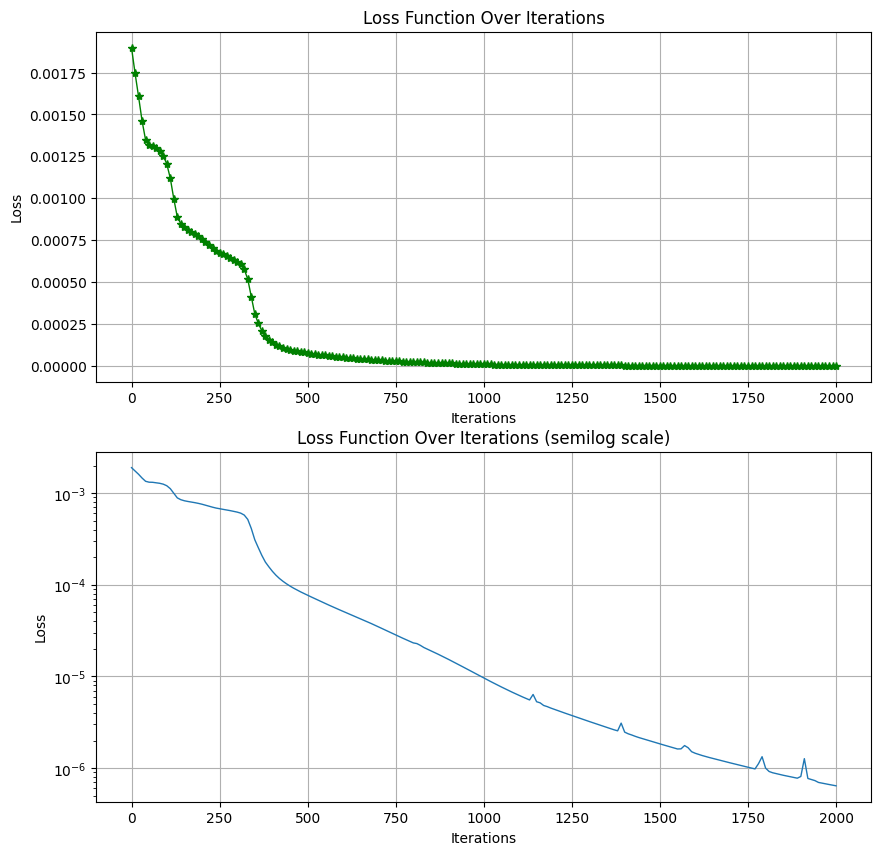

In [23]:
plot_loss(history)

### Prediction

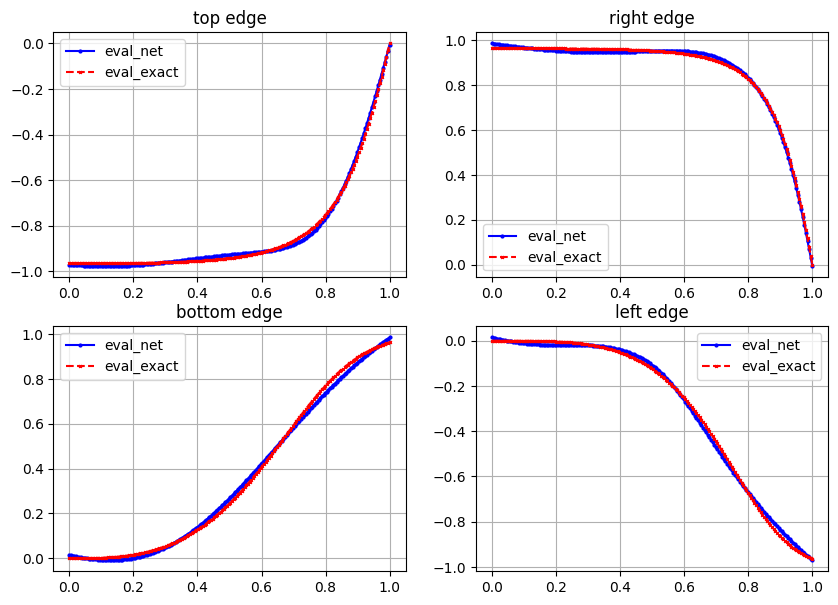

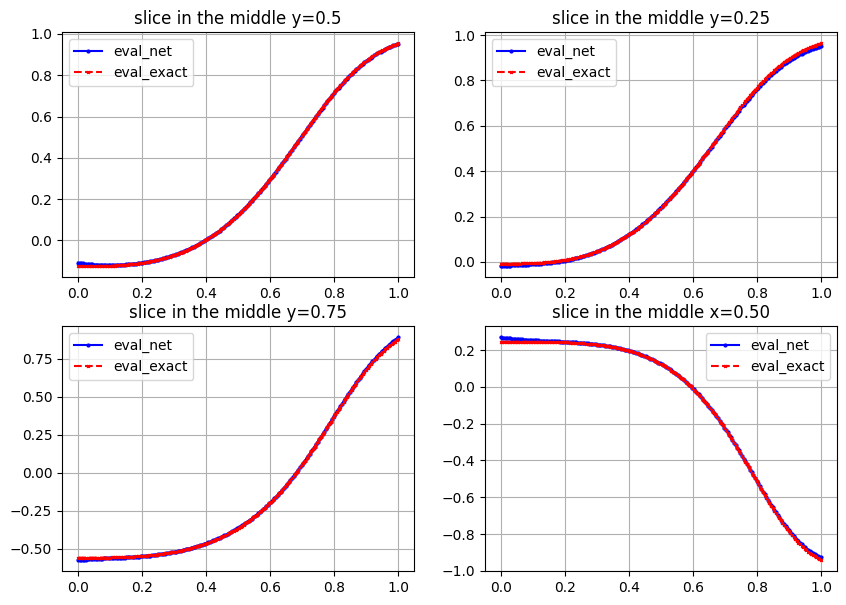

In [24]:
plot_BC(pb.u_exact_np,vp.u_NN_BC)

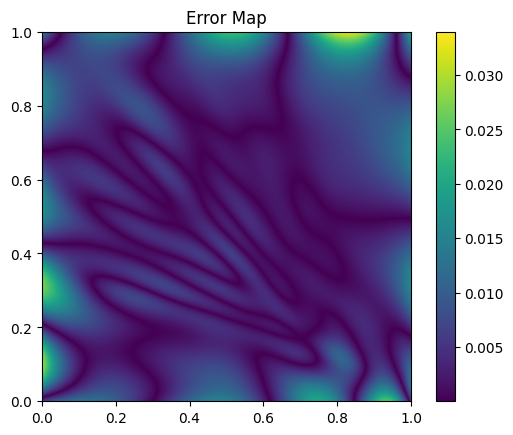

In [ ]:
color_plot(vp.NN_imposeBC)

### Residuals

In [25]:
# Find the residuals over vertices and edges
if N_test == 1:
    residual_ending_vertices = vp.calc_residuals()   # r = 1 case
    vp.residual_summary(residual_ending_vertices)   # r = 1 case
elif N_test == 2:
    residual_ending_vertices, residual_ending_edges = vp.calc_residuals()  # r = 2
    vp.residual_summary(residual_ending_vertices,residual_ending_edges)  # r = 2


residual of vertices : 
-->max  =  6.92954686725126e-06
-->min  =  2.3815295868546796e-12
-->mean =  6.47789085683553e-07
residual of edges : 
-->max  =  1.392213206809252e-05
-->min  =  1.2971549594595673e-11
-->mean =  6.371936322337623e-07


/tmp/ipykernel_21255/659253298.py:20: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  f = sp.interp2d(x, y, residual_ending_vertices, kind="linear")
/home/mariano/Documenti/test/base/lib/python3.9/site-packages/scipy/interpolate/_fitpack_impl.py:593: RuntimeWarning: No more knots can be added because the number of B-spline
coefficients already exceeds the number of data points m.
Probable causes: either s or m too small. (fp>s)
	kx,ky=1,1 nx,ny=11,13 m=88 fp=0.000000 s=0.000000
  warnings.warn(RuntimeWarning(_iermes

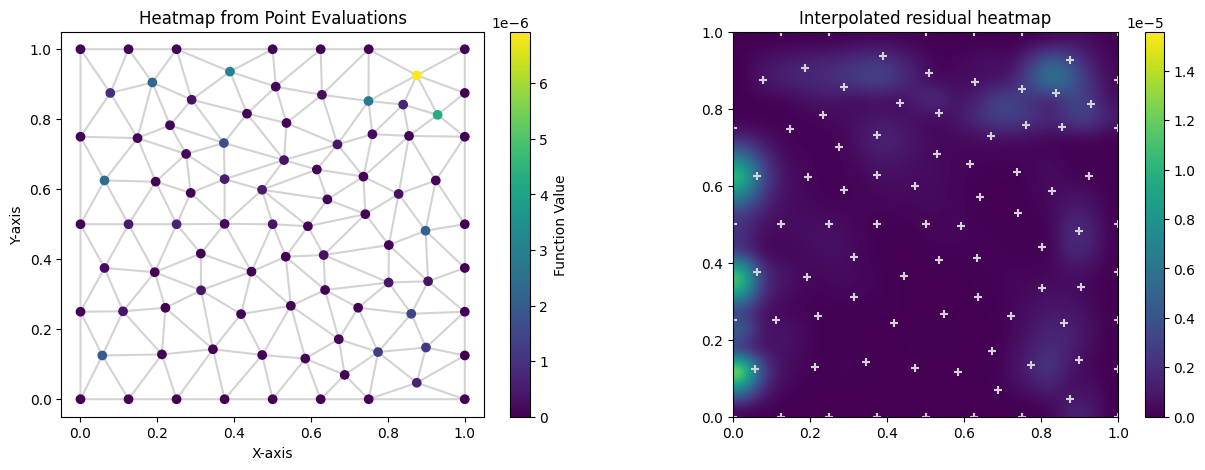

In [26]:
x = vp.mesh['vertices'][:,0]
y = vp.mesh['vertices'][:,1]

plt.figure(figsize=(15, 5))

plt.subplot(121)
plt.triplot(
    x,
    y, color='lightgrey'
)
scatter = plt.scatter(x, y, c=residual_ending_vertices, cmap='viridis', marker='o')

plt.colorbar(scatter, label='Function Value')
plt.title('Heatmap from Point Evaluations')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')

import scipy.interpolate as sp

f = sp.interp2d(x, y, residual_ending_vertices, kind="linear")

# from pylab import figure, cm
from matplotlib.colors import LogNorm

x_coords = np.linspace(0, 1, 20)
z_coords = np.linspace(0, 1, 20)
c_i = np.abs(f(x_coords, z_coords))

plt.subplot(122)
fig = plt.imshow(
    c_i,
    extent=[min(x), max(x), min(y), max(y)],
    origin="lower",
    interpolation="bicubic",
    # norm=LogNorm(vmin = np.min(c_i), vmax=np.max(c_i))
)
plt.title('Interpolated residual heatmap')
plt.scatter(x, y, color='lightgrey', marker='+')
plt.colorbar(fig)

### H1 and L2 error

In [27]:
# Get quad pairs
from numpy.polynomial import legendre


def get_quad_rule(n: int):
    # Degree of the Legendre polynomial (number of nodes - 1)

    # Nodes and weights for Gauss-Legendre quadrature
    nodes, weights = legendre.leggauss(n + 1)



    nodes=(nodes+1.0)/2.0


    # Nodes=np.array([nodes],dtype=np_type)

    Weights=np.array([weights],dtype=np_type)
    w = Weights.T @ Weights
    w = np.reshape(w, (-1,1))


    x, y =np.meshgrid(nodes,nodes)


    x = x.flatten()
    y = y.flatten()
 



    xy=np.array([x,y]).T


    return xy, w/4




In [28]:
def L2_error(xy, w):
    
    u_NN = vp.NN_imposeBC(xy)

    # Find the exact solution
    u_ex = pb.u_exact_np(xy[:,0], xy[:,1])
    u_ex = np.reshape(u_ex, (-1,1))

    integrand = (u_ex - u_NN)**2


    # Find the difference between exact and NN 
    # return (u_ex - u_NN)**2

    return np.sqrt(np.sum(w*integrand))



def semi_H1_error(xy, w):

    # Find the gradient of the exact solution
    grad_ex = np.array([pb.dudx(xy[:,0], xy[:,1]), pb.dudy(xy[:,0], xy[:,1])],dtype=np_type).T


    # Find the gradient of the NN solution
    grad_NN = vp.eval_grad_NN_BC(tf.constant(xy, dtype=tf_type))

    


    # Find the difference between exact and NN 
    pw_diff = grad_ex - grad_NN

    pw_diff = pw_diff*pw_diff


    # Return dx_error^2 + dy_error^2
    return np.sqrt(np.sum(np.sum(pw_diff,axis=1)*w))

### NETWORKS WITH EXACT BC

In [29]:
MODEL = tfk.models.Sequential()
MODEL.add(tf.keras.Input(shape=(2,),dtype=tf_type))
MODEL.add(tfkl.Dense(50, activation='tanh',kernel_initializer=initializer,dtype=tf_type,bias_initializer=initializer))
MODEL.add(tfkl.Dense(50, activation='tanh',kernel_initializer=initializer,dtype=tf_type,bias_initializer=initializer))
MODEL.add(tfkl.Dense(50, activation='tanh',kernel_initializer=initializer,dtype=tf_type,bias_initializer=initializer))
MODEL.add(tf.keras.layers.Dense(1,activation='linear',kernel_initializer=initializer,dtype=tf_type,use_bias=True))

MODEL.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 50)                150       
                                                                 
 dense_10 (Dense)            (None, 50)                2550      
                                                                 
 dense_11 (Dense)            (None, 50)                2550      
                                                                 
 dense_12 (Dense)            (None, 1)                 51        
                                                                 
Total params: 5301 (41.41 KB)
Trainable params: 5301 (41.41 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [32]:
N_test = 2

params = {'scheme': 'VPINNs','N_test':N_test}

vp=VPINN(pb,params,mesh,False,MODEL)
model=vp.u_NN_BC

-->mesh : 
     n_triangles :  150
     n_vertices  :  88
     n_edges     :  237
     h_max           :  0.25
     h_min           :  0.0895721626833764
-->test_fun      : 
     order       :  2
     dof         :  277


In [33]:
vp.set_bc_model(vp.standard_bc)

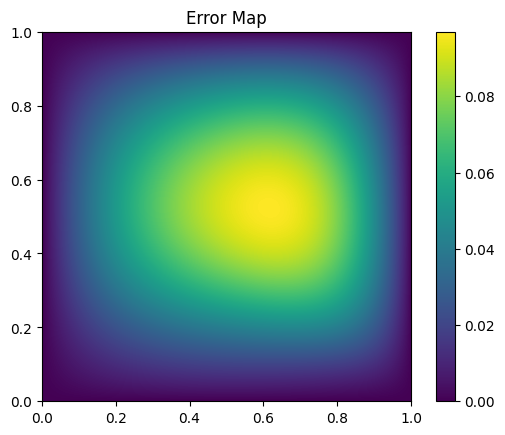

In [34]:
color_plot(vp.NN_imposeBC)

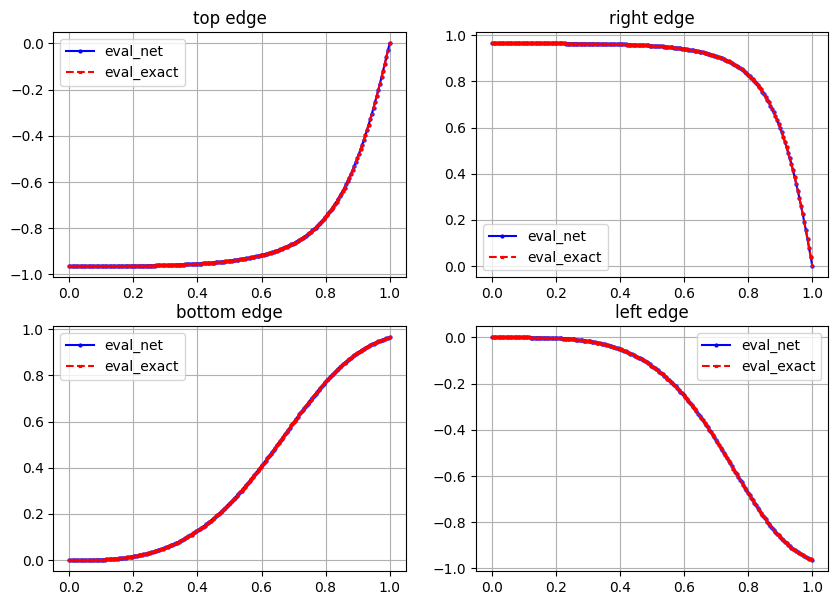

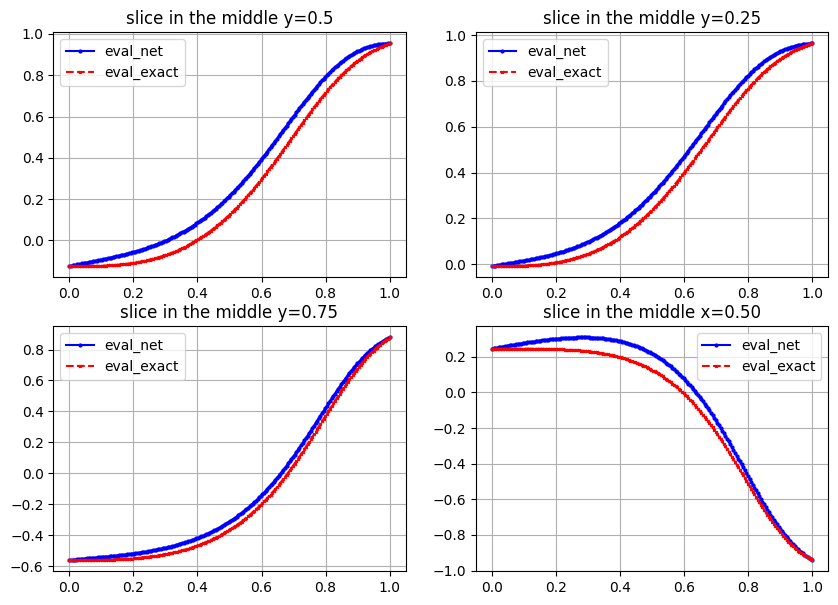

In [35]:
model =vp.NN_imposeBC

plot_BC(pb.u_exact_np,model_np)

In [36]:
history=vp.train(1000,0.001)

Iteration: 0 loss: 0.0000807601 time: 36.24933743476868
Iteration: 10 loss: 0.0000211644 time: 0.6654074192047119
Iteration: 20 loss: 0.0000167504 time: 0.7035737037658691
Iteration: 30 loss: 0.0000154169 time: 0.650416374206543
Iteration: 40 loss: 0.0000138274 time: 0.6330780982971191
Iteration: 50 loss: 0.0000136362 time: 0.6894950866699219
Iteration: 60 loss: 0.0000134309 time: 0.6680924892425537
Iteration: 70 loss: 0.0000131976 time: 0.6374201774597168
Iteration: 80 loss: 0.0000130033 time: 0.6382479667663574
Iteration: 90 loss: 0.0000128227 time: 0.629422664642334
Iteration: 100 loss: 0.0000126463 time: 0.6185703277587891
Iteration: 110 loss: 0.0000124685 time: 0.6882646083831787
Iteration: 120 loss: 0.0000122860 time: 0.6815032958984375
Iteration: 130 loss: 0.0000120964 time: 0.6545429229736328
Iteration: 140 loss: 0.0000118960 time: 0.664452314376831
Iteration: 150 loss: 0.0000116805 time: 0.6735701560974121
Iteration: 160 loss: 0.0000114451 time: 0.6694915294647217
Iteration: 1

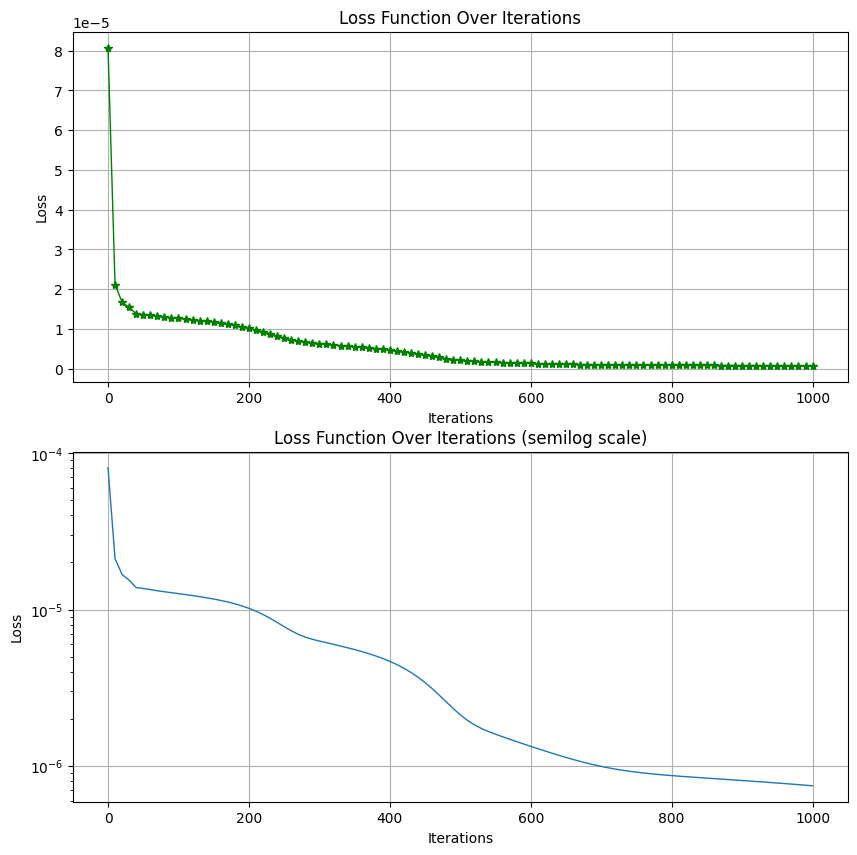

In [37]:
plot_loss(history)

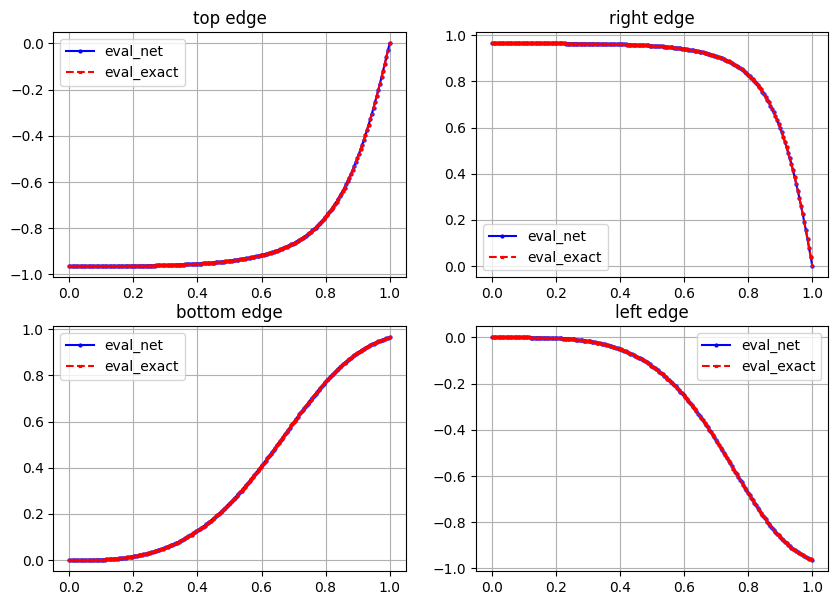

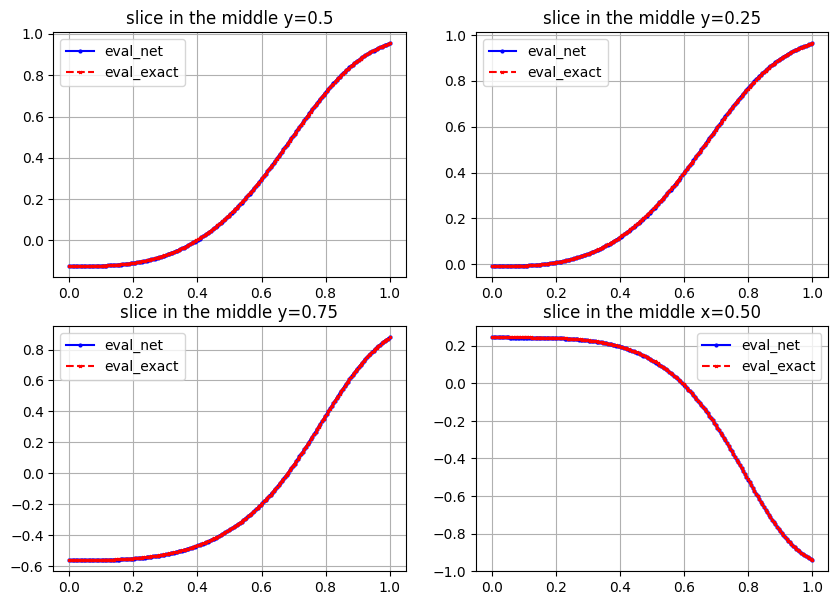

In [38]:
plot_BC(pb.u_exact_np,model_np)

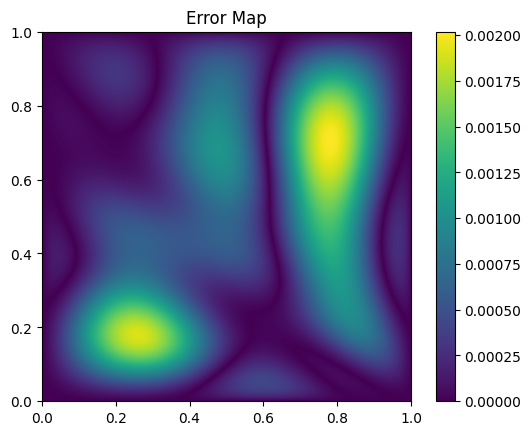

In [39]:
color_plot(vp.NN_imposeBC)

In [40]:
#set quad rule for calc errors
xy, w = get_quad_rule(30)

semi_H1_err = semi_H1_error(xy, w)
L2_error_ = L2_error(xy, w)
H1_err = np.sqrt(L2_error_**2 + semi_H1_err**2)

print(f"L2 error: {L2_error_}")
print(f"semi H1 error: {semi_H1_err}")
print(f"H1 error: {H1_err}")

L2 error: 0.000698029986130119
semi H1 error: 0.21023981513402717
H1 error: 0.21024097391672122


In [41]:
from scipy.integrate import dblquad
integral,error=dblquad(lambda x,y: (pb.u_exact(x,y)-vp.u_NN_BC(x,y))*(pb.u_exact(x,y)-vp.u_NN_BC(x,y)), 0.0, 1.0,0.0,1.0)


print('dnlquad :')
print(np.sqrt(integral))


dnlquad :
0.000698023189914262


### H1 and L2 convergence

-->mesh : 
     n_triangles :  2
     n_vertices  :  4
     n_edges     :  5
     h_max           :  1.4142135623730951
     h_min           :  1.0
-->test_fun      : 
     order       :  2
     dof         :  1
Iteration: 0 loss: 0.5957871185 time: 1.3757672309875488
Iteration: 10 loss: 0.0797330008 time: 0.015881776809692383
Iteration: 20 loss: 0.0012534518 time: 0.01726818084716797
Iteration: 30 loss: 0.0057711897 time: 0.020184040069580078
Iteration: 40 loss: 0.0043722738 time: 0.01594829559326172
Iteration: 50 loss: 0.0007720048 time: 0.017954349517822266
Iteration: 60 loss: 0.0000064702 time: 0.014969587326049805
Iteration: 70 loss: 0.0000383346 time: 0.02057671546936035
Iteration: 80 loss: 0.0000464210 time: 0.017225980758666992
Iteration: 90 loss: 0.0000247177 time: 0.022966384887695312
Iteration: 100 loss: 0.0000097228 time: 0.017206907272338867
Iteration: 110 loss: 0.0000033589 time: 0.017276763916015625
Iteration: 120 loss: 0.0000011196 time: 0.016480684280395508
Iteration: 

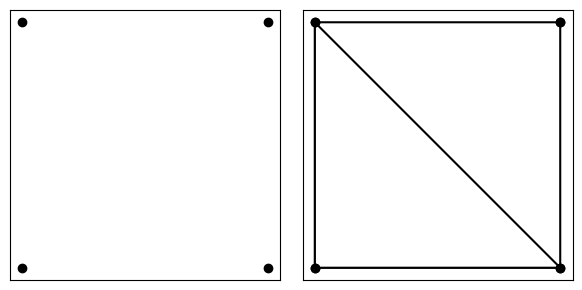

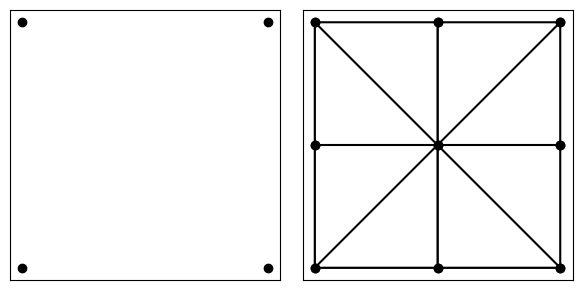

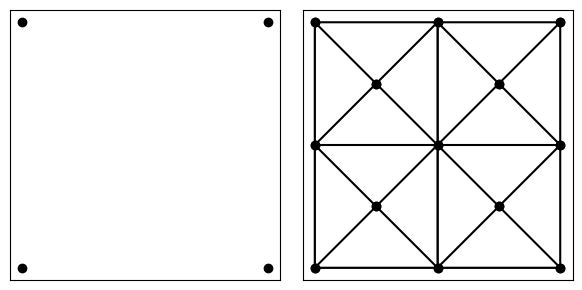

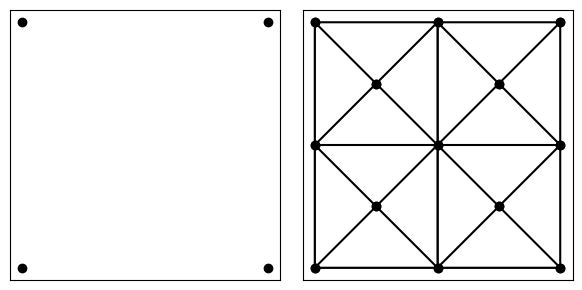

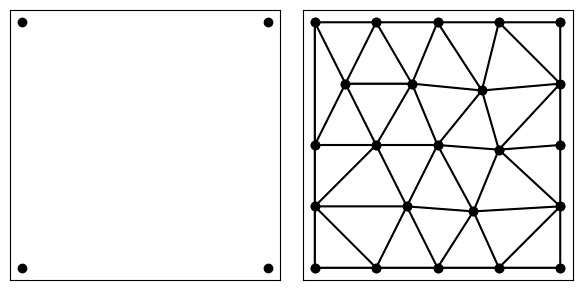

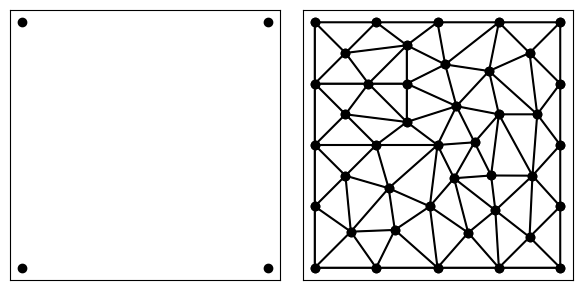

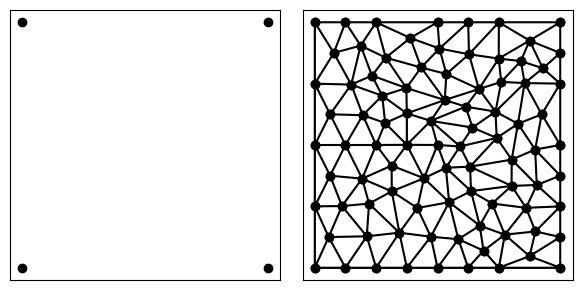

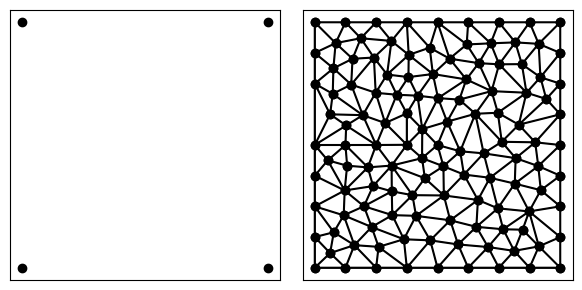

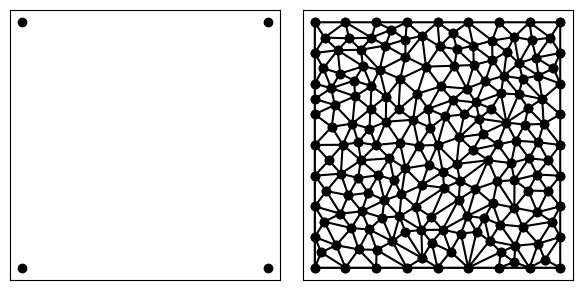

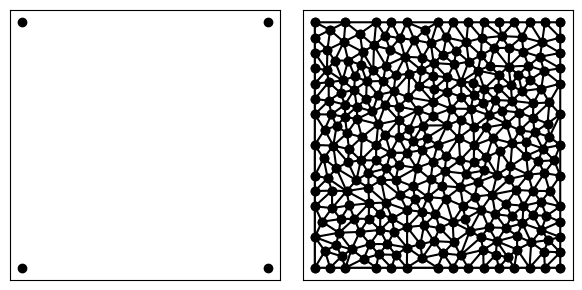

In [43]:
def restart_model():
    model = tfk.models.Sequential()
    model.add(tf.keras.Input(shape=(2,),dtype=tf.float64))
    model.add(tfkl.Dense(50, activation='tanh',kernel_initializer=initializer,dtype=tf_type,bias_initializer=initializer))
    model.add(tfkl.Dense(50, activation='tanh',kernel_initializer=initializer,dtype=tf_type,bias_initializer=initializer))
    model.add(tfkl.Dense(50, activation='tanh',kernel_initializer=initializer,dtype=tf_type,bias_initializer=initializer))
    model.add(tf.keras.layers.Dense(1,activation='linear',kernel_initializer=initializer,dtype=tf_type,use_bias=True))
    return model

xy, w = get_quad_rule(30)

H1 = []
L2 = []
semi = []
h = []

for refinement in [0.5, 0.2, 0.1, 0.075, 0.05, 0.025, 0.01, 0.008, 0.005, 0.003]:
    model = restart_model()
    mesh=generate_mesh(domain,refinement)
    vp=VPINN(pb,params,mesh,False,model)
    history=vp.train(1000, 0.001)


    L2_error_=L2_error(xy,w)


    #semi_H1_err2, int_error_semi_H1 = dblquad(semi_H1_error, 0.0, 1.0, 0.0, 1.0, epsabs=1E-5)
    #semi_H1_err = np.sqrt(semi_H1_err2)
    #H1_err = np.sqrt(L2_error**2 + semi_H1_err**2)

    #H1.append(H1_err)
    #semi.append(semi_H1_err)
    L2.append(L2_error_)
    a, b = find_hs(mesh)
    h.append(0.5*a + 0.5*b)
    
    

In [44]:
h = np.array(h)

#H1 = np.array(H1)
L2 = np.array(L2)
#semi = np.array(semi)

L2 rate: 0.25844358202315837


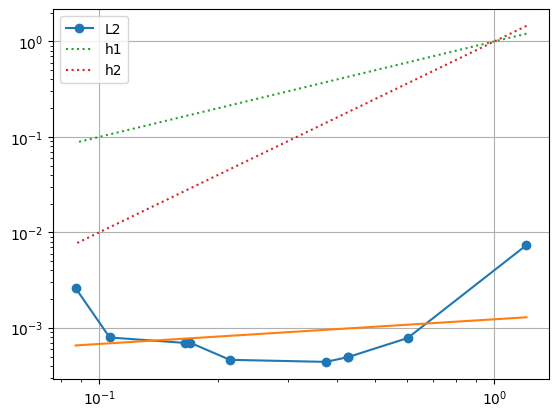

In [45]:
# slope_H1, intercept_H1 = np.polyfit(h, H1, 1)
# slope_L2, intercept_L2 = np.polyfit(h, L2, 1)

#coeffs = np.polyfit(np.log10(h), np.log10(H1), 1)
#polynomial = np.poly1d(coeffs)
#log10_H1_fit = polynomial(np.log10(h))

#print(f"H1 rate: {coeffs[0]}")

coeffs = np.polyfit(np.log10(h), np.log10(L2), 1)
polynomial = np.poly1d(coeffs)
log10_L2_fit = polynomial(np.log10(h))

print(f"L2 rate: {coeffs[0]}")

#plt.loglog(h, H1, marker='o', label='H1')
plt.loglog(h, L2, marker='o', label='L2')
#plt.loglog(h, semi, marker='o', label='semi')
#plt.loglog(h, 10**log10_H1_fit)
plt.loglog(h, 10**log10_L2_fit)
plt.loglog(h, h, linestyle=':', label='h1')
plt.loglog(h, h*h, linestyle=':', label='h2')
plt.grid()
plt.legend()